### Group Project Phase #2

For our predictive question, we are asking if specific quantitative characteristics of a track (danceability and energy) can help predict a new song's popularity on the music streaming service, Spotify.

Idea for Phase #2: Conduct regression analyses with two predictive variables to see which results in the smallest RSME.

First, we load any necessary packages required for our data cleaning and wrangling, analyses, and visualizations.

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(RColorBrewer)

options(repr.plot.width= 30, repr.plot.height= 10)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

We then read in our chosen dataset from our GitHub repository. In order to ensure that our analyses are reproducible, we used the set.seed function (set to an arbritrary number) to generate the same random selection of data throughout our analysis to maintain consistent results.

In [3]:
set.seed(2022)

spotify_raw_data = read_csv("https://raw.githubusercontent.com/chrislukita/DSCI100-Group-Final/main/data/SpotifyDataset.csv")

Parsed with column specification:
cols(
  genre = col_character(),
  artist_name = col_character(),
  track_name = col_character(),
  track_id = col_character(),
  popularity = col_double(),
  acousticness = col_double(),
  danceability = col_double(),
  duration_ms = col_double(),
  energy = col_double(),
  instrumentalness = col_double(),
  key = col_character(),
  liveness = col_double(),
  loudness = col_double(),
  mode = col_character(),
  speechiness = col_double(),
  tempo = col_double(),
  time_signature = col_character(),
  valence = col_double()
)

Warning message:
“1 parsing failure.
   row col   expected     actual                                                                                             file
115177  -- 18 columns 15 columns 'https://raw.githubusercontent.com/chrislukita/DSCI100-Group-Final/main/data/SpotifyDataset.csv'
”


Since our dataset is quite sizeable, we decided to cut it roughly in half to cut down on data processing time while still maintaining a considerable amount of data for training and testing our regression model.

In [4]:
random_spotify = slice_sample(spotify_raw_data, n = 50000)

After cutting our data set, we perform some data wrangling to select only our desired columns (popularity, danceability, and energy), as well as omitting any "NA" values that may interfere with our data analysis. These steps help clean up the data by removing any values that are unnecessary for our particular analysis.

In [6]:
spotify_wrangled = random_spotify %>%
                    select(popularity, danceability, energy) %>%
                    na.omit(spotify_wrangled)
spotify_wrangled

popularity,danceability,energy
<dbl>,<dbl>,<dbl>
88,0.553,0.502
52,0.450,0.840
56,0.414,0.267
61,0.544,0.446
64,0.704,0.558
51,0.549,0.888
50,0.470,0.988
39,0.722,0.763
49,0.395,0.977


In [133]:
# spotify_wrangled = spotify_wrangled %>%
#                     mutate(popular = popularity >= 65) %>%
#                     mutate(popular = as.factor(popular))

# levels(spotify_wrangled$popular)[2] <- 'Yes'
# levels(spotify_wrangled$popular)[1] <- 'No'

^guess we can delete hey?

In [13]:
# options(repr.plot.width= 15, repr.plot.height= 10)

# spotify_really_small = slice_sample(spotify_wrangled, n = 1000)

# popularity_plot = spotify_really_small %>%
#                 ggplot(aes(x = energy, y = danceability
#                            , color = popular)) + 
#                 geom_point()

# popularity_plot

^dang and this haha

In [9]:
spotify_split = initial_split(spotify_wrangled, prop = 0.75, strata = popularity)

spotify_train = training(spotify_split)
spotify_test = testing(spotify_split)

In [10]:
# spotify_proportions = spotify_train %>%
#             group_by(popular) %>%
#             summarize(n = n()) %>%
#             mutate(percent = 100*n/nrow(spotify_train))

# spotify_proportions

^prob delete as well?

**Tuning model to find best K value using two predictors**

Here we create our model's recipe using the training data set, where we inidicate the response variable and the desired predictors. In the recipe we also scale and center the data so that the values are being compared using relative scales and metrics to avoid  one or more variables exhibiting disproportionate influence on the model's outputs.

In [11]:
spotify_recipe <- recipe(popularity ~ danceability + energy, data = spotify_train) %>%
                        step_scale(all_predictors()) %>%
                        step_center(all_predictors())

spotify_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Operations:

Scaling for all_predictors()
Centering for all_predictors()

Next, we create the model specifications using the knn algorithm for regression which predicts the response variable's value based on the values of neighbouring points. Since, we want to find the optimal value of neighbours that reduce's our model's RMSE, we set neighbours to "tune()" while we continue to train the model.

In [12]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn") %>%
            set_mode("regression")

In [14]:
spotify_vfold <- vfold_cv(spotify_train, v = 5, strata = popularity)

In [15]:
spotify_results <- workflow() %>%
                      add_recipe(spotify_recipe) %>%
                      add_model(knn_tune) %>%
                      tune_grid(resamples = spotify_vfold, grid = 10) %>%
                      collect_metrics()

In [20]:
spotify_rmse <- spotify_results %>% 
        filter(.metric == "rmse")
spotify_rmse

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,rmse,standard,20.57846,5,0.06316393,Model01
3,rmse,standard,19.64028,5,0.07025384,Model02
5,rmse,standard,18.81895,5,0.06910413,Model03
6,rmse,standard,18.61078,5,0.07478422,Model04
7,rmse,standard,18.47275,5,0.07390812,Model05
8,rmse,standard,18.35581,5,0.07234437,Model06
9,rmse,standard,18.26115,5,0.06925482,Model07
12,rmse,standard,18.05051,5,0.06516387,Model08
13,rmse,standard,18.00890,5,0.06668086,Model09


Plot accuracies vs. K

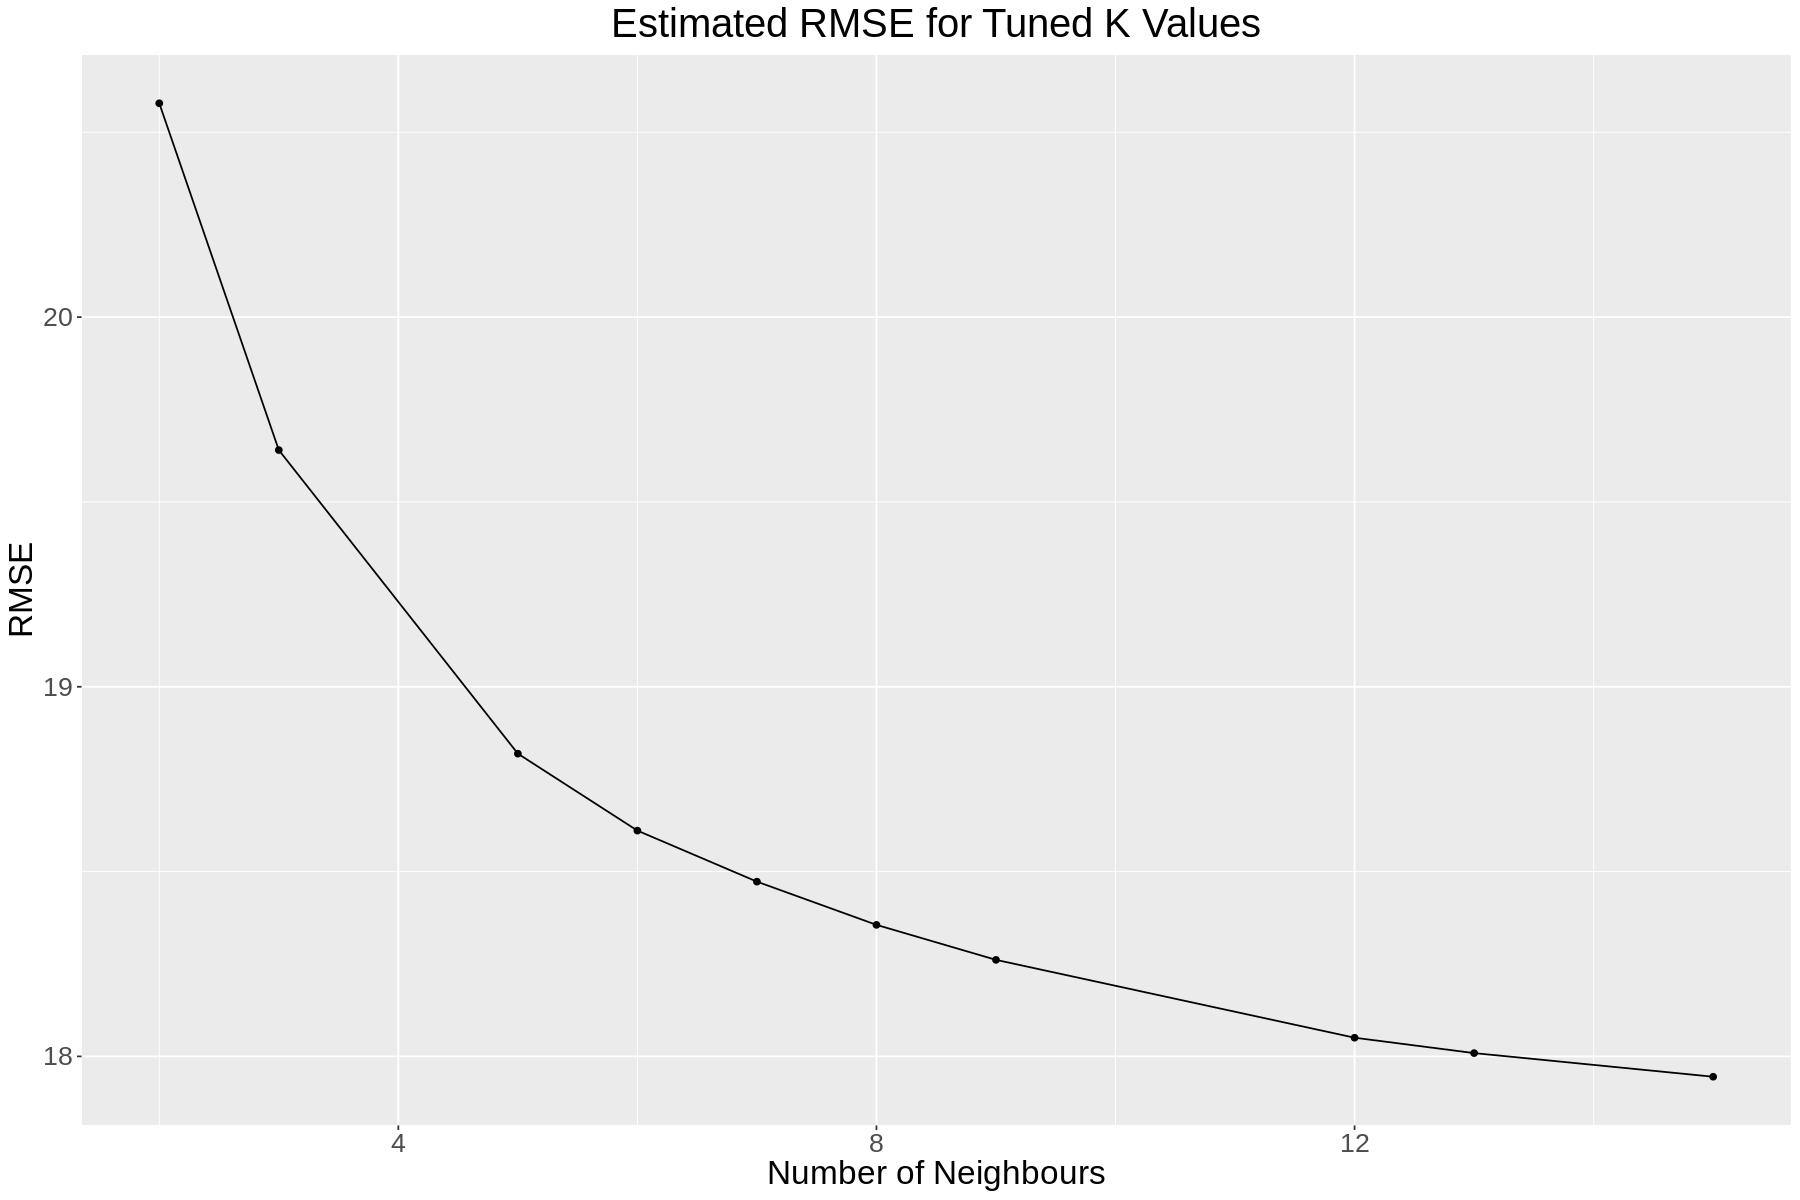

In [21]:
options(repr.plot.width= 15, repr.plot.height= 10)

accuracies_plot = spotify_rmse %>% 
                ggplot(aes(x = neighbors, y = mean)) + 
                geom_point() +
                geom_line() + 
                labs(x = "Number of Neighbours", y = "RMSE") +
                ggtitle("Estimated RMSE for Tuned K Values") + 
                theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20)) 

accuracies_plot

**I didn't change anything past this point**

Working with 9 neighbours

In [61]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) %>%
            set_engine("kknn") %>%
            set_mode("classification")

knn_fit = workflow() %>%
            add_recipe(spotify_recipe_3) %>%
            add_model(knn_spec) %>%
            fit(data = spotify_train)

testing_predicted_9 = predict(knn_fit, spotify_test) %>%
                bind_cols(spotify_test) %>%
                metrics(truth = popular, estimate = .pred_class) %>%
                filter(.metric == "accuracy") 

testing_predicted_9

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.93976


Working with 15 neighbours

In [62]:
knn_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 15) %>%
            set_engine("kknn") %>%
            set_mode("classification")

knn_fit_2 = workflow() %>%
            add_recipe(spotify_recipe_3) %>%
            add_model(knn_spec_2) %>%
            fit(data = spotify_train)

testing_predicted_15 = predict(knn_fit, spotify_test) %>%
                bind_cols(spotify_test) %>%
                metrics(truth = popular, estimate = .pred_class) %>%
                filter(.metric == "accuracy") 

testing_predicted_15

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.93976


In [63]:
accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9190133,5,0.001065499,Model1
4,accuracy,binary,0.9249067,5,0.001654838,Model2
6,accuracy,binary,0.9342400,5,0.001535014,Model3
8,accuracy,binary,0.9374400,5,0.001895210,Model4
9,accuracy,binary,0.9395467,5,0.001728506,Model5
10,accuracy,binary,0.9395467,5,0.001716120,Model6
11,accuracy,binary,0.9400533,5,0.001855490,Model7
13,accuracy,binary,0.9404800,5,0.001844921,Model8
15,accuracy,binary,0.9404533,5,0.001809899,Model9
